**Introduction:**

For the Module 4 Final Project, we will be examining a dataset from Zillow, of over 14,000 ZIP codes and their respective median home value. Our aim here is to narrow down to the 5 best ZIP codes for our stakeholders, a real estate investment company, to make an investment in. We will define our best investment in this case as low-risk with good return on investment (ROI) for 5 years. The way we have structured this project is by first dividing the data up into 3 equal portions by percentile of the dataset's median price distribution. We will then get the top 5-Year, 10-Year, and 15-year ROIs for each 1/3, and pick a least visually volatile trend from each set, making an ARIMA model for each.

# Obtaining Our Data

First, let's import our libraries necessary for this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from matplotlib.pylab import rcParams
import itertools

Let's now import the zillow data set and get a quick look at what it contains.

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


We can see there are 14,723 rows, which are all different zipcodes. We can also see the median house prices of each zipcode for every month from 1996 to 2018, with the months as columns. This makes our dataset wide format- something that will need to be adjusted to long format in order to run our model later on.

Right off the bat, we are only going to need to know the zipcode, and the median house prices, so all other columns can be dropped. After some referencing, we know that RegionName refers to the zipcode and that zipcodes which have only 4 numbers are actually zipcodes which begin with a 0 as this is mostly likely a pandas numerical format thing (not really an issue, just a note!).

While we are at it, let's rename 'RegionName' to 'zipcode'

# Data Preprocessing and Filtering

In [3]:
df.drop(columns=['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], inplace=True)
df.rename({'RegionName': 'zipcode'}, axis='columns', inplace=True)

In [4]:
df.isna().any()

zipcode    False
1996-04     True
1996-05     True
1996-06     True
1996-07     True
           ...  
2017-12    False
2018-01    False
2018-02    False
2018-03    False
2018-04    False
Length: 266, dtype: bool

So there are a few missing values for the earlier months. This is due to the fact that some zipcodes are quite new!

After some initial domain research, I found that many real estate investment firms typically look at 5-year, 10-year, and over-10-year time frame for return on investment (ROI). As our data is still in wide-format, let's create a few additional columns that calculate for the most recent 5Y, 10Y, and 15Y ROI's (%) for each zip code. These values will be our assumed return on investments (ROI), if one were to purchased a home at those times.

In [5]:
df['5Y-ROI'] = round((((df['2018-04']-df['2013-04']) / df['2013-04']) * 100), 3)
df['10Y-ROI'] = round((((df['2018-04']-df['2008-04']) / df['2008-04']) * 100), 3)
df['15Y-ROI'] = round((((df['2018-04']-df['2003-04']) / df['2003-04']) * 100), 3)

In [6]:
df.head()

,zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,5Y-ROI,10Y-ROI,15Y-ROI
0,60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,26.083,19.131,39.101
1,75070,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,...,314100,315000,316600,318100,319600,321100,321800,53.384,52.367,69.547
2,77494,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,...,320400,320800,321200,321200,323000,326900,329900,28.316,32.224,50.228
3,60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,25.879,14.238,32.596
4,79936,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,...,120300,120300,120300,120300,120500,121000,121500,7.048,-5.300,49.080


Great! We have the 5-year, 10-year, and 15-year profit categories for each zipcode. Now let's do some filtering based on our most recent values. 
____

First, let's check the 5-point statistics for our set, and get an idea of the distribution of home values. Since we are planning on dividing up the values by 3, let's set our percentiles to roughly equal 1/3s. 

In [7]:
df['2018-04'].describe(percentiles=[.33, .66])

count    1.472300e+04
mean     2.880399e+05
std      3.720544e+05
min      1.380000e+04
33%      1.518260e+05
50%      1.981000e+05
66%      2.636000e+05
max      1.789490e+07
Name: 2018-04, dtype: float64

We can see that the mean value for April 2018 (most recent) for the entire set is ~ (about) 288,000, while the median is ~198,000. The 75th percentile is only ~321,000 and the max value of the set goes all the way to ~17,000,000. 

We want to give our stakeholders, the real estate investment firm, some options for investing. Narrowing our initial selection of zipcodes based on 3 levels most recent values such as might also help leverage what our stakeholders are considering high risk at the moment. Let's try splitting up our data based on the distribution of our dataset so that we have a roughly even amount of houses in each category : < 151,826 (33%), between 151,826 - 263,600 (33% - 66%), and > 263,600 (66%). 

In [8]:
under_33 = df[df['2018-04'] < 151826]
bet33_66 = df[(df['2018-04'] >= 151826) &
             (df['2018-04'] < 263600)]
above_66 = df[df['2018-04'] >= 263600]

Quick check to make sure that worked:

In [9]:
under_33['2018-04'].describe()

count      4859.000000
mean     107445.215065
std       28494.383592
min       13800.000000
25%       85600.000000
50%      110500.000000
75%      132050.000000
max      151800.000000
Name: 2018-04, dtype: float64

## Top Zipcodes < 33rd Percentile
Top 2 ROIs for zipcodes where the median home value is under the 33rd percentile:

In [10]:
print(under_33[['zipcode','5Y-ROI']].sort_values(by=['5Y-ROI'], ascending=False).head())
print('\n')
print(under_33[['zipcode','10Y-ROI']].sort_values(by=['10Y-ROI'], ascending=False).head())
print('\n')
print(under_33[['zipcode','15Y-ROI']].sort_values(by=['15Y-ROI'], ascending=False).head())

      zipcode   5Y-ROI
5830    48240  161.224
2782    48237  137.798
4952    34234  137.677
4138    33830  135.778
1202    30034  135.688


       zipcode  10Y-ROI
13908    38388  120.339
13335    74740   99.254
6934     15211   98.762
8172     79756   93.398
13740    58563   81.225


       zipcode  15Y-ROI
9296     28762  257.500
13421    38568  193.907
13908    38388  189.809
12104    26541  160.078
13335    74740  153.481


Great, now we have the top contenders for ROI in each category. Now let's take the top 5 zips from each sub-group and put them in separate dataframes for EDA later on. We will then repeat this process for each tier of values.

In [11]:
fiveyear_33 = under_33[(under_33.zipcode.isin(['48240','48237 ','34234','33830','30034']))]
tenyear_33 = under_33[(under_33.zipcode.isin(['38388','74740','15211','79756','58563']))]
fifteenyr_33 = under_33[(under_33.zipcode.isin(['28762','38568','38388','26541','74740']))]

## Top Zipcodes in 33-66th Percentile
Top 2 ROIs for zipcodes where the median home value is between the 33rd and 66th percentiles:

In [12]:
print(bet33_66[['zipcode','5Y-ROI']].sort_values(by=['5Y-ROI'], ascending=False).head())
print('\n')
print(bet33_66[['zipcode','10Y-ROI']].sort_values(by=['10Y-ROI'], ascending=False).head())
print('\n')
print(bet33_66[['zipcode','15Y-ROI']].sort_values(by=['15Y-ROI'], ascending=False).head())

      zipcode   5Y-ROI
2661    33705  159.211
6105    37210  155.932
2627    33460  153.647
6563    15201  147.594
1835    37207  146.683


       zipcode  10Y-ROI
6563     15201  166.475
2452     58801  155.946
11167    58318  139.255
1928     15206  130.519
4195     27701  120.211


       zipcode  15Y-ROI
3615     19125  447.599
6563     15201  313.393
666      19145  292.481
3325     15213  231.162
13099    96772  223.747


In [13]:
fiveyear_mid = bet33_66[(bet33_66.zipcode.isin(['33705','37210','33460','15201','37207']))]
tenyear_mid = bet33_66[(bet33_66.zipcode.isin(['15201','58801','58318','15206','27701']))]
fifteenyr_mid = bet33_66[(bet33_66.zipcode.isin(['19125','15201','19145','15213','96772']))]

## Top Zipcodes > 66th Percentile
Top 5 ROIs for zipcodes where the median home value is above the 66th percentile:

In [14]:
print(above_66[['zipcode','5Y-ROI']].sort_values(by=['5Y-ROI'], ascending=False).head())
print('\n')
print(above_66[['zipcode','10Y-ROI']].sort_values(by=['10Y-ROI'], ascending=False).head())
print('\n')
print(above_66[['zipcode','15Y-ROI']].sort_values(by=['15Y-ROI'], ascending=False).head())

      zipcode   5Y-ROI
7302    80216  173.873
1477    94601  167.943
1239    94590  159.379
475     11216  147.592
1681    94606  140.110


      zipcode  10Y-ROI
2580    94043  160.110
1155    11222  157.611
5738    94301  156.475
117     11211  147.969
2054    94303  146.453


       zipcode  15Y-ROI
117      11211  522.346
1155     11222  502.626
475      11216  446.191
70       11221  297.838
13591    95389  267.971


In [15]:
fiveyear_top = above_66[(above_66.zipcode.isin(['80216','94601','94590','11216','94606']))]
tenyear_top = above_66[(above_66.zipcode.isin(['94043','11222','94301','11211','94303']))]
fifteenyr_top = above_66[(above_66.zipcode.isin(['11211','11222','11216','11221','95389']))]

# EDA
## Under $151,000 USD

Let's define the helper function that melt's our data frame from wide format to date-time, long format for convenient graphing and also modeling later on.

In [10]:
def melt_data(df):
    df.drop(columns=['5Y-ROI','10Y-ROI','15Y-ROI'], inplace=True)
    melted = pd.melt(df, id_vars=['zipcode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

Now, let's define another function for plotting the time series of any dataframe we feed into it.

In [11]:
def plot_all_zips(df):
    for zcode in df.zipcode.unique():
        plot_df = df[df.zipcode == zcode].set_index('time')
        plot_df['value'].plot(figsize=(15,8), label=zcode)
    plt.legend(loc="best")
    plt.xlabel;

Optimized font settings for matplotlib visualizations:

### ROI Comparison

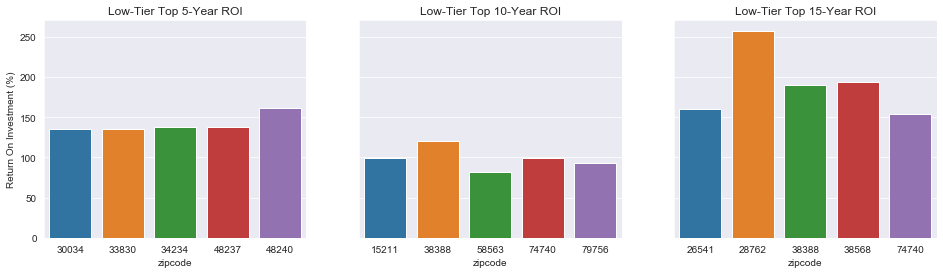

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 4))


sns.barplot(x=df.zipcode[(df.zipcode.isin(['48240','48237 ','34234','33830','30034']))], y='5Y-ROI', data=df, ax=ax1)
ax1.set_title('Low-Tier Top 5-Year ROI')
ax1.set_ylabel('Return On Investment (%)')
sns.barplot(x=df.zipcode[(df.zipcode.isin(['38388','74740','15211','79756','58563']))], y='10Y-ROI', data=df, ax=ax2)
ax2.set_ylabel('')
ax2.set_title('Low-Tier Top 10-Year ROI')
sns.barplot(x=df.zipcode[(df.zipcode.isin(['28762','38568','38388','26541','74740']))], y='15Y-ROI', data=df, ax=ax3)
ax3.set_ylabel('')
ax3.set_title('Low-Tier Top 15-Year ROI')

plt.savefig('low-tier-roi.png')
plt.show();



### Top 5-Year ROIs
Let's now melt down and plot our top 5 contenders under $151,000 for 5-year ROIs.

In [19]:
melted1 = melt_data(fiveyear_33)

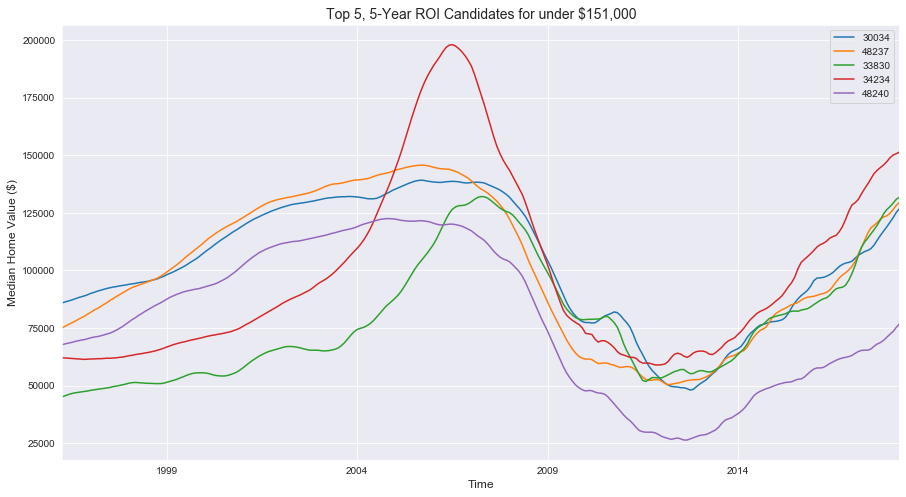

In [20]:
plot_all_zips(melted1)
plt.title('Top 5, 5-Year ROI Candidates for under $151,000', size=14)
plt.xlabel('Time', size=12)
plt.ylabel('Median Home Value ($)', size=12);

All 5 of these zipcodes suffered heavily in the 2007/'08 financial crisis. However, since hitting bottom, these zipcodes outperformed the rest in the last 5 years. We could say any of the 5Y zip code is a risky choice being that the median home price there dropped so heavily in the crisis (high volatility). 

Top Pick out of the top-5: None, too volatile.

Seeing this, we know we can reasonably give a longer time frame more importance. Let's check the 10-year investment contenders.
### Top 10-Year ROIs

In [21]:
meltd_tenyr_33 = melt_data(tenyear_33)

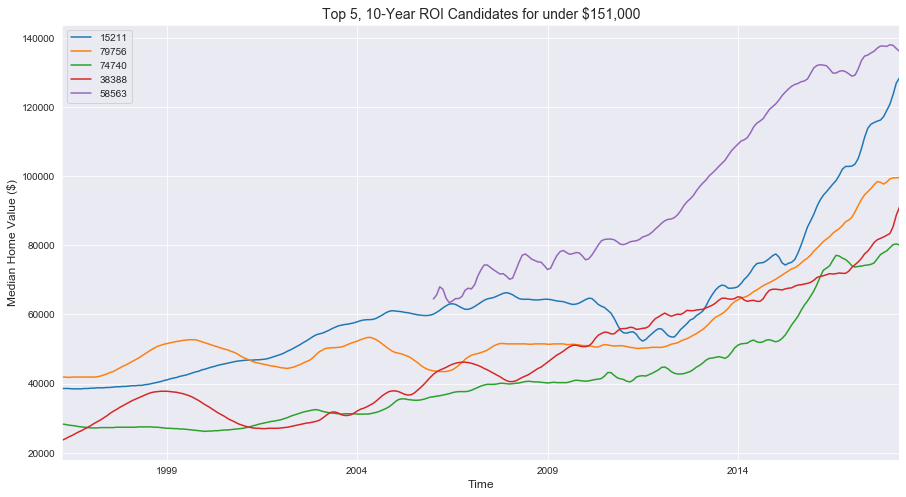

In [22]:
plot_all_zips(meltd_tenyr_33)
plt.title('Top 5, 10-Year ROI Candidates for under $151,000', size=14)
plt.xlabel('Time', size=12)
plt.ylabel('Median Home Value ($)', size=12);

There is considerably more stability in the top contenders for 10-year investments as opposed to the top 5-year investments. This would be an indicator of lower risk for us. 
Note: the 58563 area is missing the lower half of it's values because it is a newly-created zip code (for New Salem, North Dakota)- not a problem for now.

Our top Pick: 74740 seems to have the least volatility with a steady increase. As these 5 are all top profit performers out of thousands of zipcodes, we don't have to worry about #1 greatest profit and will be safer trusting our investment firms money in a less volatile environment.

### Top 15-Year ROIs

In [23]:
meltd_15yr_33 = melt_data(fifteenyr_33)

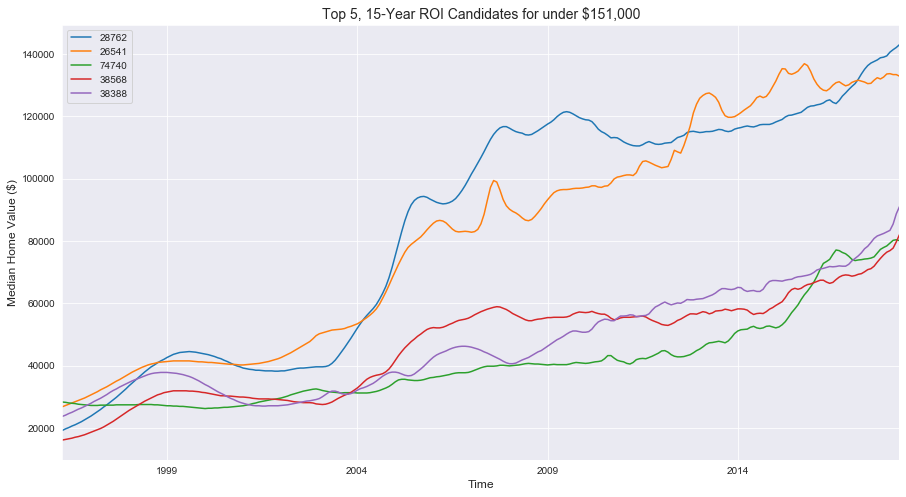

In [24]:
plot_all_zips(meltd_15yr_33)
plt.title('Top 5, 15-Year ROI Candidates for under $151,000', size=14)
plt.xlabel('Time', size=12)
plt.ylabel('Median Home Value ($)', size=12);

The top 5 contenders for 15-year investments also managed some resistance against the housing crisis, with slight dips. Remember, these 15-Year ROIs were much higher than 10-Year or 5-Year.

Our top pick: 38388 is visually the closet in stability to 74740, which have already chosen. 38388 also outperformed 74740 by about 40% in ROI.

## 151,000 - $263,600 USD

### ROI Comparison

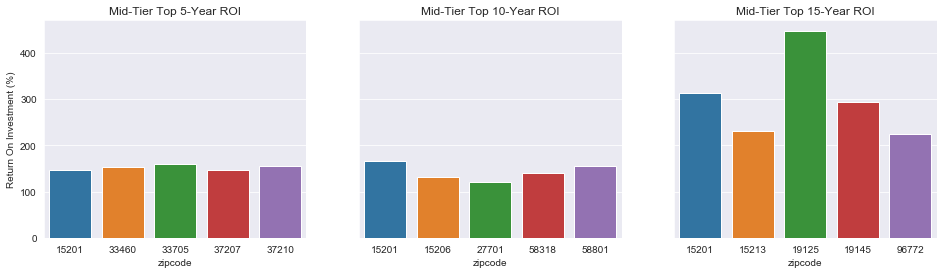

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 4))

sns.barplot(x=df.zipcode[(df.zipcode.isin(['33705','37210','33460','15201','37207']))], y='5Y-ROI', data=df, ax=ax1)
ax1.set_title('Mid-Tier Top 5-Year ROI')
ax1.set_ylabel('Return On Investment (%)')
sns.barplot(x=df.zipcode[(df.zipcode.isin(['15201','58801','58318','15206','27701']))], y='10Y-ROI', data=df, ax=ax2)
ax2.set_ylabel('')
ax2.set_title('Mid-Tier Top 10-Year ROI')
sns.barplot(x=df.zipcode[(df.zipcode.isin(['19125','15201','19145','15213','96772']))], y='15Y-ROI', data=df, ax=ax3)
ax3.set_ylabel('')
ax3.set_title('Mid-Tier Top 15-Year ROI')

plt.savefig('mid-tier-roi.png')
plt.show();

### Top 5-Year ROIs

In [26]:
meltd_5yr_mid = melt_data(fiveyear_mid)

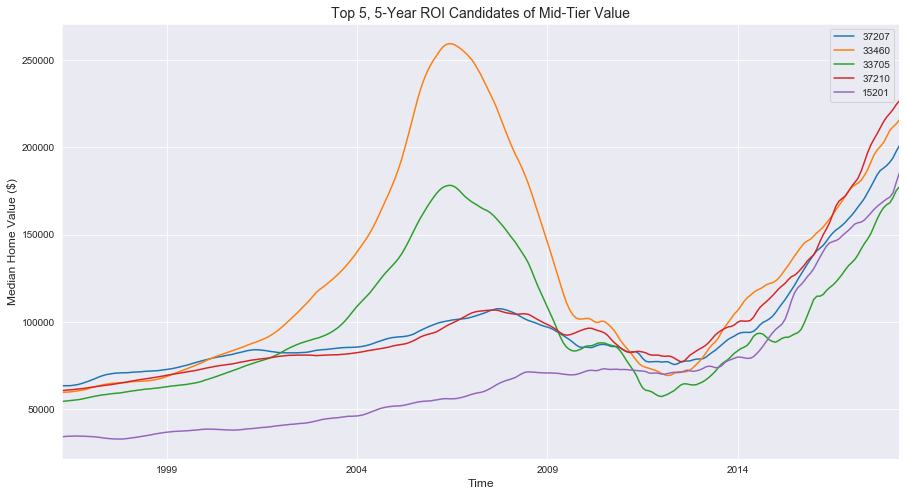

In [27]:
plot_all_zips(meltd_5yr_mid)
plt.title('Top 5, 5-Year ROI Candidates of Mid-Tier Value', size=14)
plt.xlabel('Time', size=12)
plt.ylabel('Median Home Value ($)', size=12);

2 of the top 5 zips here dipped heavily in the '08 crisis (33460 - Lake Worth, FL), and the rest were mildly affected. 15201 however, seemed to be barely impacted at all, which is a good indicator of stability/low-risk.

Out Top Pick: 15201. Best stability.

### Top 10-Year ROIs

In [28]:
meltd_10yr_mid = melt_data(tenyear_mid)

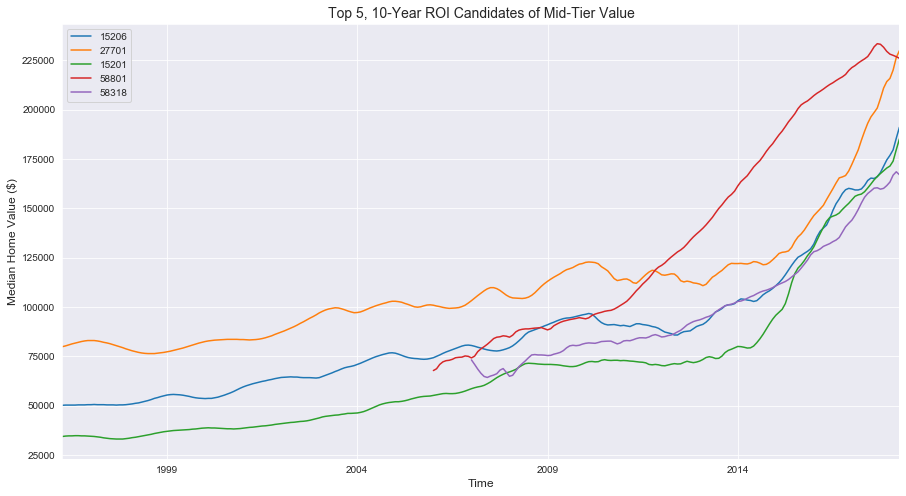

In [29]:
plot_all_zips(meltd_10yr_mid)
plt.title('Top 5, 10-Year ROI Candidates of Mid-Tier Value', size=14)
plt.xlabel('Time', size=12)
plt.ylabel('Median Home Value ($)', size=12);

As we noticed in the low-tier valued homes, the 10-year ROIs were barely impacted by the crisis. ROIs here are quite stable upward trend, with some exponential rise in the last 10 years.

Top Pick: 15206. High returns and low volatility. Could be close to 15201 which we chose already.

### Top 15-Year ROIs


In [30]:
meltd_15yr_mid = melt_data(fifteenyr_mid)

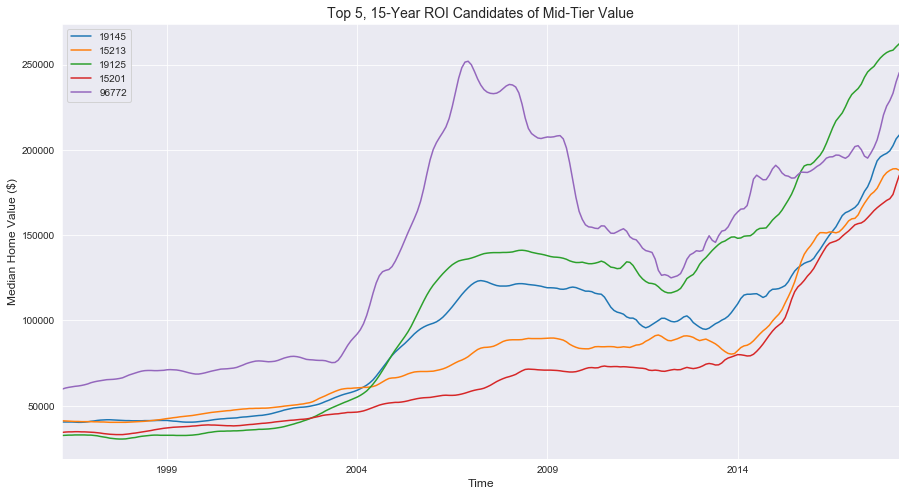

In [31]:
plot_all_zips(meltd_15yr_mid)
plt.title('Top 5, 15-Year ROI Candidates of Mid-Tier Value', size=14)
plt.xlabel('Time', size=12)
plt.ylabel('Median Home Value ($)', size=12)
plt.savefig('top5-15yROI-ts.png');

A bit of a mix here. 96772 (Naleehu, Hawaii) had a significant dip. 15201 (Pittsburgh, Pennsylvania) was steadily increasing throughout the crisis. Stability is good for investing! That could be a choice for our mid-tier valued homes.

Our Top Pick: 15213. It has the second best stability after 15201, which we chose already!

## Above $263,600 USD

### ROI Comparison

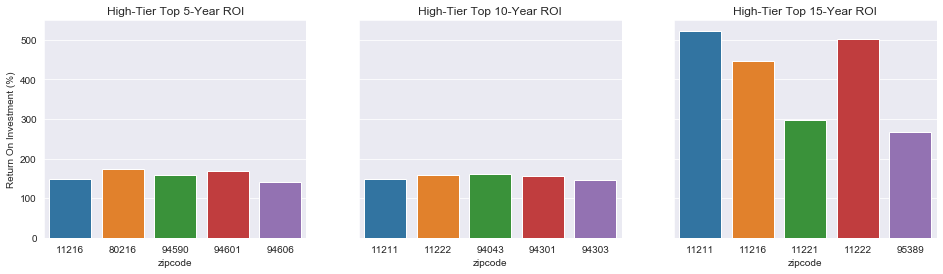

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 4))

sns.barplot(x=df.zipcode[(df.zipcode.isin(['80216','94601','94590','11216','94606']))], y='5Y-ROI', data=df, ax=ax1)
ax1.set_title('High-Tier Top 5-Year ROI')
ax1.set_ylabel('Return On Investment (%)')
sns.barplot(x=df.zipcode[(df.zipcode.isin(['94043','11222','94301','11211','94303']))], y='10Y-ROI', data=df, ax=ax2)
ax2.set_ylabel('')
ax2.set_title('High-Tier Top 10-Year ROI')
sns.barplot(x=df.zipcode[(df.zipcode.isin(['11211','11222','11216','11221','95389']))], y='15Y-ROI', data=df, ax=ax3)
ax3.set_ylabel('')
ax3.set_title('High-Tier Top 15-Year ROI')
plt.savefig('high-tier-roi.png')
plt.show();

The top tier section of our data essentially is limitless as far as value. Some of these ZIP codes hit upwards of $15M in median value. 

Another note is that nearly all of these top profit ZIP codes are either in NYC or California (no big surprise there).

### Top 5-Year ROIs

In [33]:
meltd_5yr_top = melt_data(fiveyear_top)

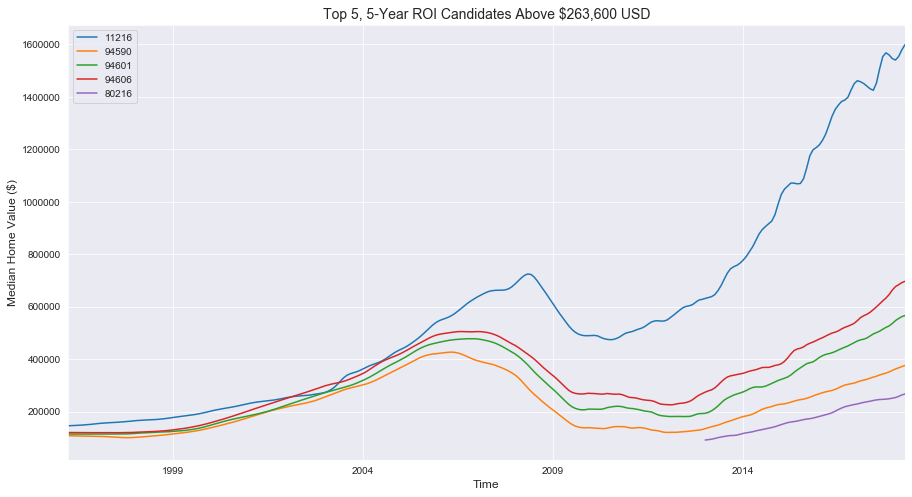

In [34]:
plot_all_zips(meltd_5yr_top)
plt.title('Top 5, 5-Year ROI Candidates Above $263,600 USD', size=14)
plt.xlabel('Time', size=12)
plt.ylabel('Median Home Value ($)', size=12);

Some volatility here. 80216 does well yet is either missing data or is a newly added zip code. 

Our Top pick: 94606. Ok volatility, and decent profits.

### Top 10-Year ROIs

In [35]:
meltd_10yr_top = melt_data(tenyear_top)

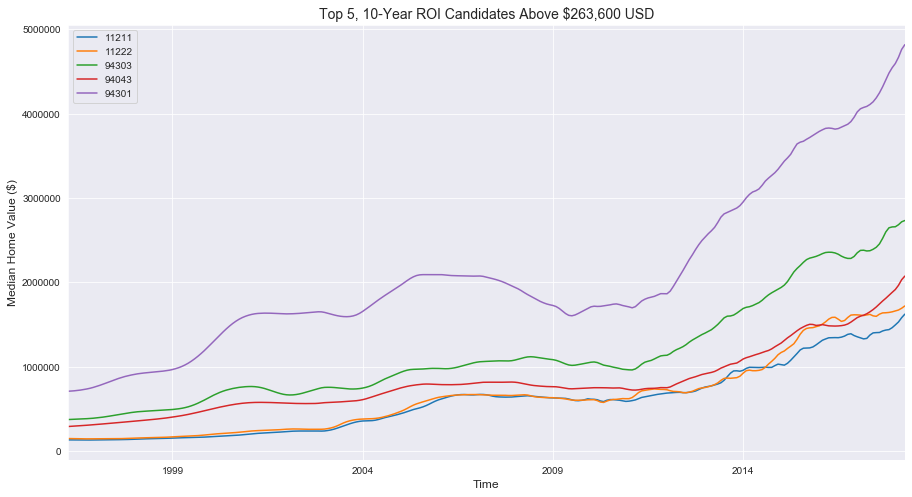

In [36]:
plot_all_zips(meltd_10yr_top)
plt.title('Top 5, 10-Year ROI Candidates Above $263,600 USD', size=14)
plt.xlabel('Time', size=12)
plt.ylabel('Median Home Value ($)', size=12);

Our top pick: 94043, minimal volatility, solid trend upwards!

### Top 15-Year ROIs

In [37]:
meltd_15yr_top = melt_data(fifteenyr_top)

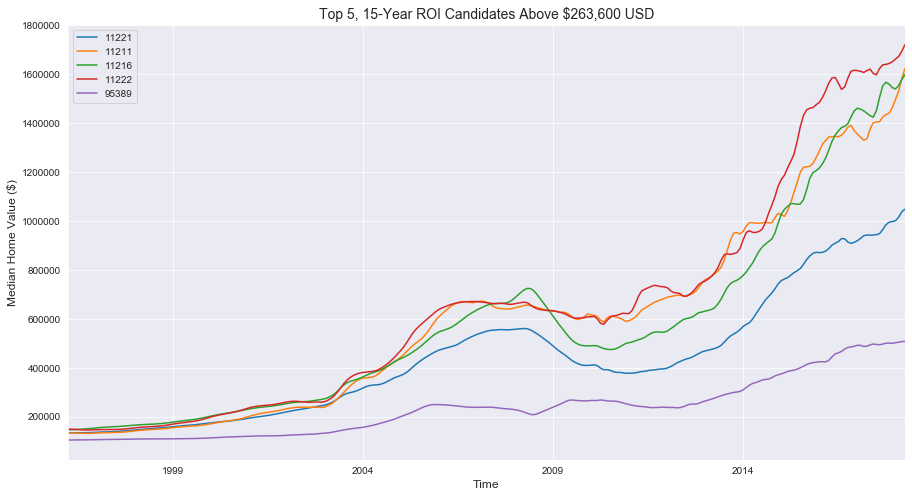

In [38]:
plot_all_zips(meltd_15yr_top)
plt.title('Top 5, 15-Year ROI Candidates Above $263,600 USD', size=14)
plt.xlabel('Time', size=12)
plt.ylabel('Median Home Value ($)', size=12);

The top-tier valued 15-year ROIs were higher than all of the other categories. Some with dips during the crisis, however the post-crisis values far exceeded pre-crisis values. All zips here are in NYC or California.

Our Top Pick: 95389. This is actually a ZIP code out in Yosemite National Park, CA, (where there are homes). Given that it is well known now that many are moving out of NYC due to the coronavirus and prices are dipping, well-spaced lands are being sought out. 

## Top Pick: 15201 (Pittsburgh, Pennsylvania)

What we noticed during our EDA is that 15201 (Arsenal, Pittsburgh, Pennsylvania), a mid-tier median-value ZIP code, displayed strong stability and resistance to the financial crisis in 2008. This zipcode was the only one in all the top-5 for 5-year, 10-year, and 15-year investment return periods. As such, let's use this ZIP code for our baseline modeling.

**Why did this ZIP code do so well?**

Our theory: Big Tech. 5 of the top big tech companies also have moved into Pittsburgh since 2006, in large part due to the exceptional work performed by student researchers at Carnegie Mellon University, which many companies wanted to tap into. We are talking Google (moved in at 2006), Facebook, Apple, Microsoft, and Uber. This absolutely contributed to the rise in housing prices, because these companies hire and pay a lot of people. This potentially helped resist high volatility during the housing crisis.

In [39]:
toppick_pitts_pa = bet33_66[(bet33_66.zipcode.isin(['15201']))]
toppick_pitts_pa

,zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,5Y-ROI,10Y-ROI,15Y-ROI
6563,15201,34400.0,34600.0,34700.0,34700.0,34800.0,34800.0,34700.0,34700.0,34600.0,...,167600,169000,170400,171400,173900,179700,185200,147.594,166.475,313.393


In [40]:
meltd_top_pick = melt_data(toppick_pitts_pa)
meltd_top_pick.drop(columns=['zipcode'], inplace=True)
meltd_top_pick.set_index('time', inplace=True)

In [41]:
meltd_top_pick

,value
time,
1996-04-01,34400.0
1996-05-01,34600.0
1996-06-01,34700.0
1996-07-01,34700.0
1996-08-01,34800.0
...,...
2017-12-01,170400.0
2018-01-01,171400.0
2018-02-01,173900.0


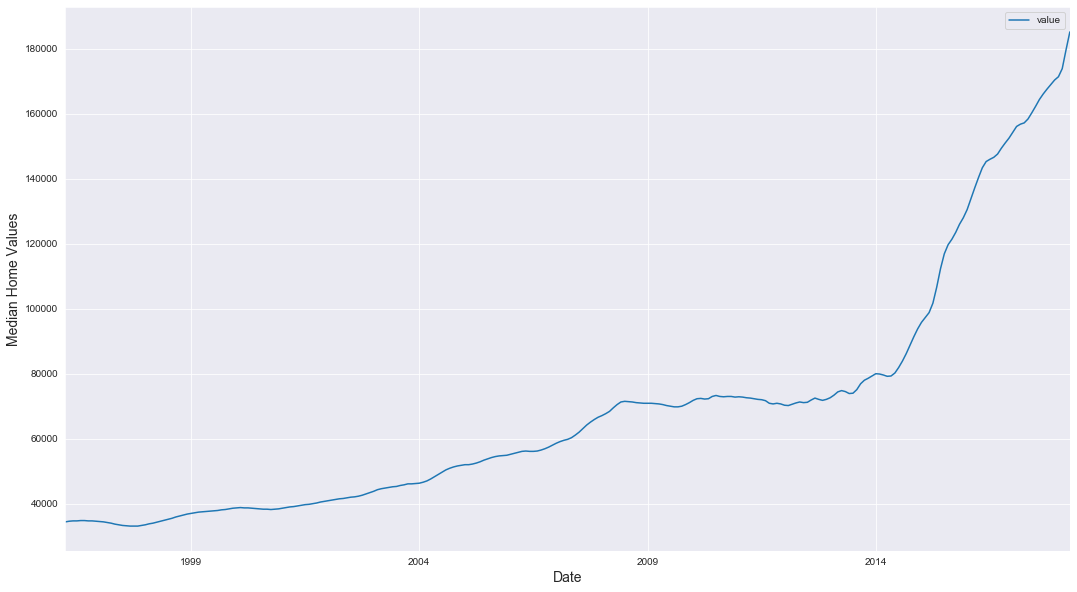

In [42]:
meltd_top_pick.plot(figsize = (18,10))
plt.xlabel('Date', fontsize=14)
plt.ylabel('Median Home Values', fontsize=14);

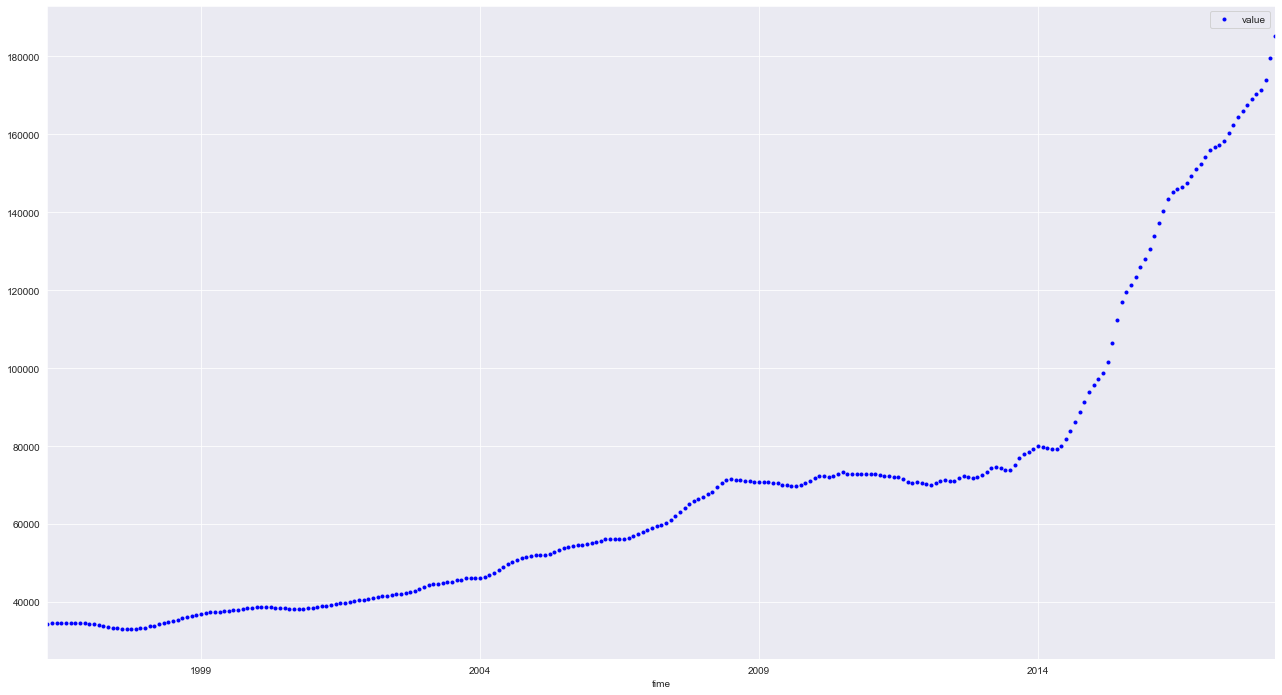

In [43]:
meltd_top_pick.plot(figsize = (22,12), style = 'b.')
plt.show()

Let's zoom in and see if we can observe any seasonal trends as people are less likely to move during the winter.

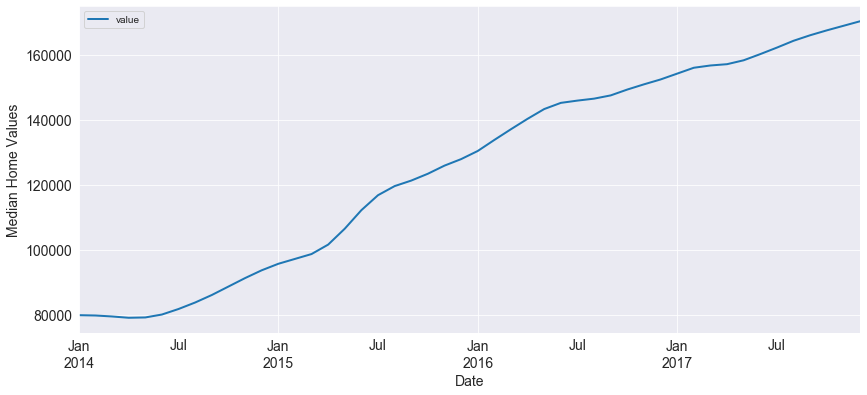

In [44]:
data_slice= meltd_top_pick['2014':'2017']
data_slice.plot(figsize=(14,6), linewidth=2, fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Median Home Values', fontsize=14);

While the trend continues upwards, there appears to be a very slight slowing down during the winter months. People tend to move less during the winter due to the unsafe conditions.

Let's plot the rolling average/variance and see if it varies over time, using 6 as the window size (time period) for 6 months.

In [45]:
roll_mean = meltd_top_pick.rolling(window=6, center=False).mean()
roll_std = meltd_top_pick.rolling(window=6, center=False).std()

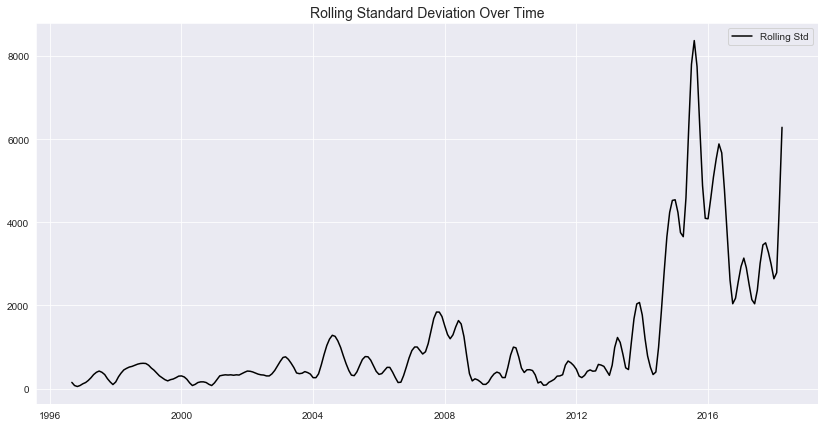

In [46]:
fig = plt.figure(figsize=(14,7))
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Standard Deviation Over Time', size=14)
plt.show(block=False)

The standard deviation jumps up when the price value increase becomes exponential.  Note the y-scale though- 8000 is not a lot when the median goes up to $180k. 

Let's get a 10-year slice of our top pick, starting from the beginning of the housing crisis, and then plot each year.

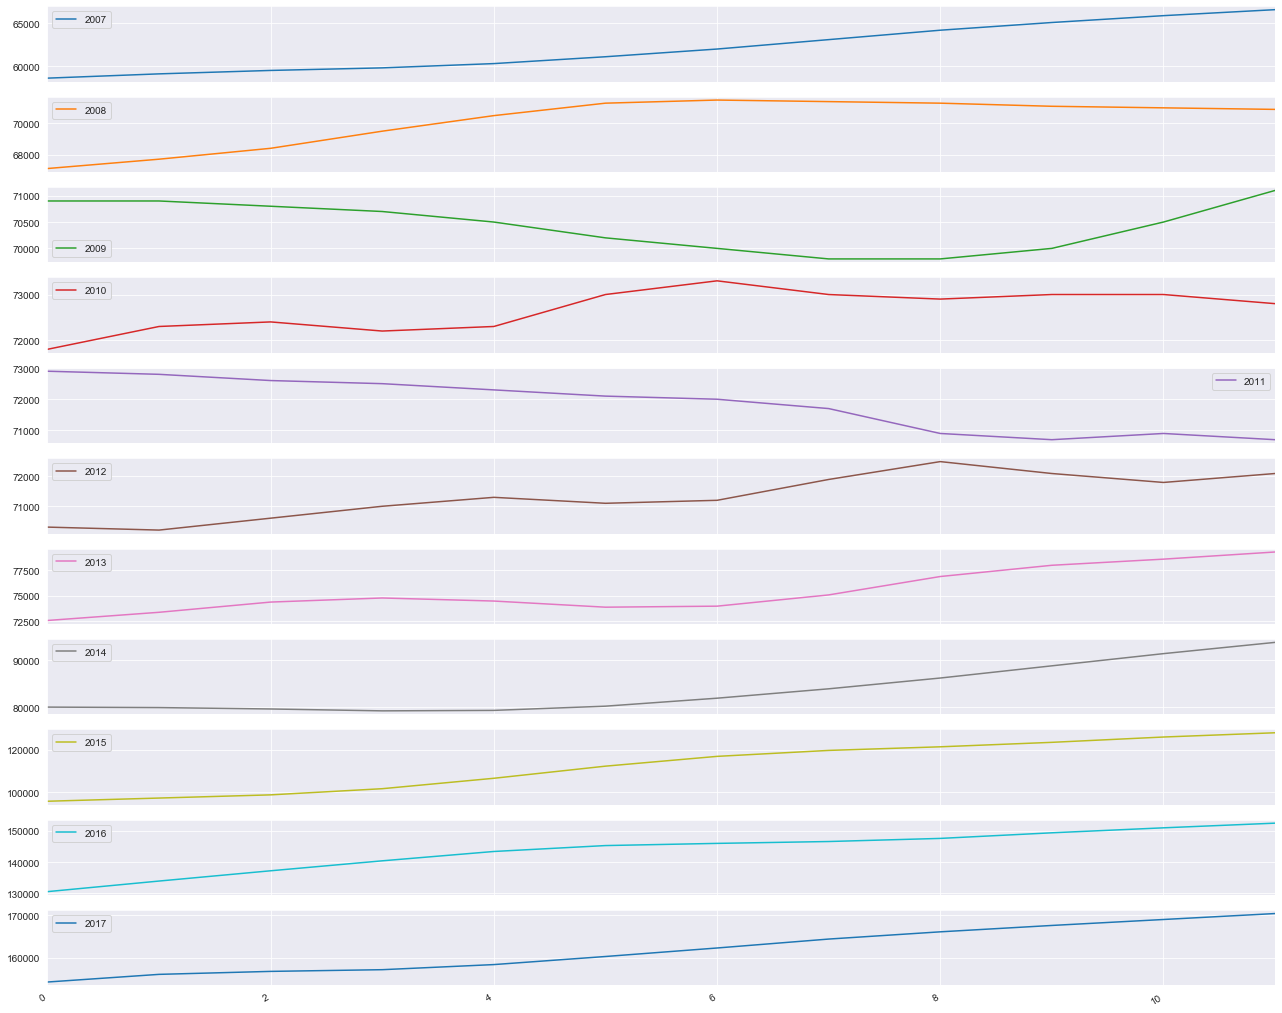

In [47]:
slice_10yr = meltd_top_pick['2007':'2017']         
year_groups = slice_10yr.groupby(pd.Grouper(freq ='A'))  #Grouping by year ('A' for annual)

# Creating a new DataFrame and storing yearly values in columns  
toppick_annual = pd.DataFrame() 

for yr, group in year_groups:
    toppick_annual[yr.year] = group.values.ravel()

# Plot the yearly groups as subplots
toppick_annual.plot(figsize = (22,20), subplots=True, legend=True)
plt.show()

With these yearly subplots, it is a bit easier to read the changes for each year. Following the 2008 crisis, there was in fact a small dip in value (about 1.4%) in 2009, which actually was completely recovered in rest of that same year. 2011 showed a decline in price (about 2.7%) throughout the entire year as well. Otherwise, all other years showed an increase.

Let's plot each of these 10 years on the same graph:

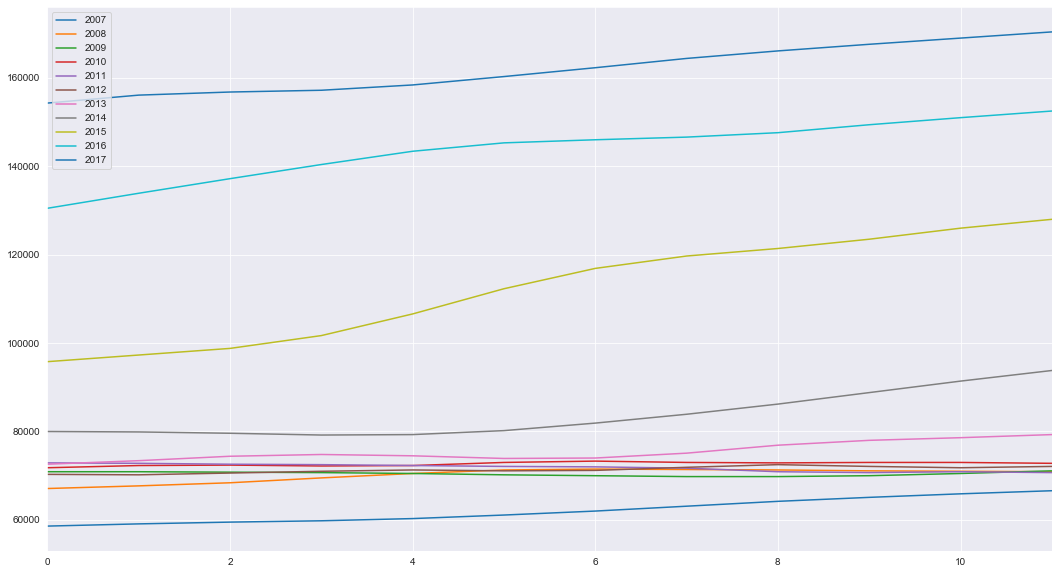

In [48]:
toppick_annual.plot(figsize = (18,10), subplots=False, legend=True)
plt.show()

With all separate years on the same graph, we can easier visualize the nearly exponential increase in the recent years as the gaps between the lines are much wider on top.

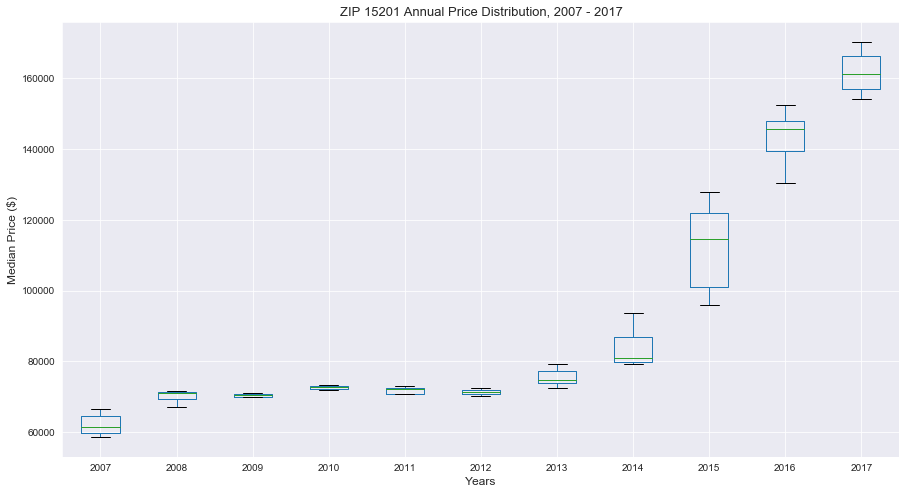

In [49]:
toppick_annual.boxplot(figsize = (15,8))
plt.title('ZIP 15201 Annual Price Distribution, 2007 - 2017', size=13)
plt.ylabel('Median Price ($)', size=12)
plt.xlabel('Years', size=12)
plt.savefig('boxplot-15201.png');

Let's plot a boxplot for the sliced 10 years up until 2017.

This box plot helps visualize the period of consolidation following the financial crisis, and then the absolute explosion of value following 2013.

Let's now decompose our top pick to separate trend from seasonality and random residuals left after seasonality is removed.

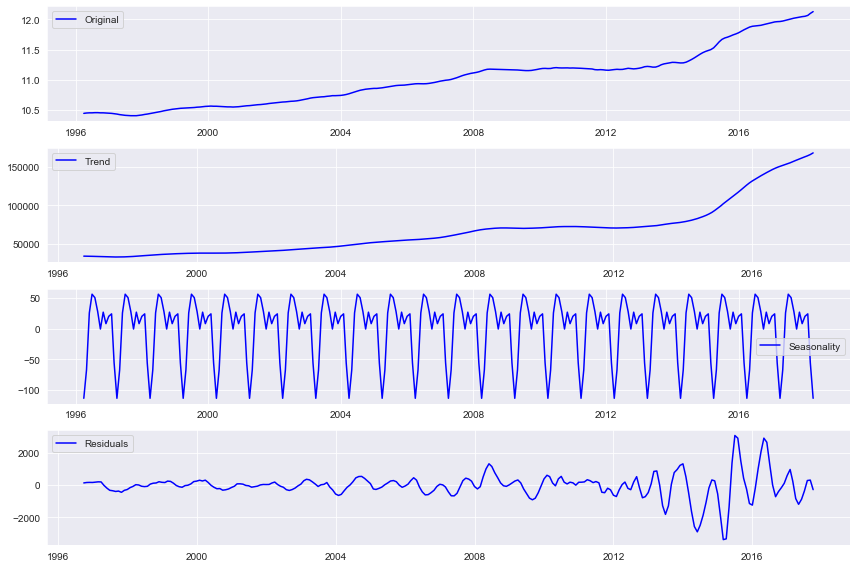

In [50]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(meltd_top_pick)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(meltd_top_pick), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('15201_decomposition.png')

We obviously knew there was a significant trend just by looking at our earlier plot of this time series. Seasonality however, was not so apparent because it's scale was so small. Taking at the seasonality plot, we can see seasonality is in fact present.

# BASELINE SARIMA MODEL: TOP PICK

Now that we've picked our top zip code, let's use it to create our baseline model. We will set a range of values for our best parameter search, for p, d, q, and P, D, Q, s.

'p' is the number of Auto-Regressive terms (the AR part of the model). It is basically the lag, incorporating the trends past values to provide predictions.

'd' is the number of differences (I, integrated) that our model subtracts from the current observation.

'q is the number of moving average terms (the MA part), which sets the error as a linear combo of the error values observed from previous time points.

The capital variables are the same idea for seasonality.
___

As we noticed slight seasonality, let's experiment running SARIMA (keeping the seasonality portion).

We will set our p, d, q parameter range between 0 and 2 for starters.

In [51]:
# Let's set the p, d and q parameters to take any value between 0 and 1.
p = d = q = range(0, 2)

# Generates all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

Now let's use a nested for loop to iterate through all combinations of parameter values into the SARIMA model.

In [52]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(meltd_top_pick,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6695.3792264607155
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6107.384448073932
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5420.776241849965
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5163.752909573703
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5239.453757777286
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5203.851755856751
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4956.439164105075
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4938.452686904047
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6479.88211119836
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =21899.90005371441
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5228.725512910743
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =6381.1555994735445
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6170.658051965766
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6123.768577962786
ARIMA (0, 0, 1) x (

Let's now find which combo of parameters gave us the minimum AIC value.

In [53]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3530.36
Name: 63, dtype: object

Let's now plug these best parameters into a new model and print the output summary table.

In [54]:
# Plugging those best parameter values into a new SARIMA model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(meltd_top_pick, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fitting the model and printing results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8378      0.025     33.883      0.000       0.789       0.886
ma.L1          0.6614      0.034     19.313      0.000       0.594       0.728
ar.S.L12       0.0727      0.041      1.765      0.078      -0.008       0.153
ma.S.L12      -0.9986      2.514     -0.397      0.691      -5.926       3.929
sigma2      1.369e+05   3.43e+05      0.400      0.689   -5.35e+05    8.08e+05


Our ma.S.L12 and sigma2 components have very high p-values. As 3 components are over the threshold (0.05), we will need to further adjust our model. Before that, let's run the model diagnostic visualizations to see what those results are telling us.

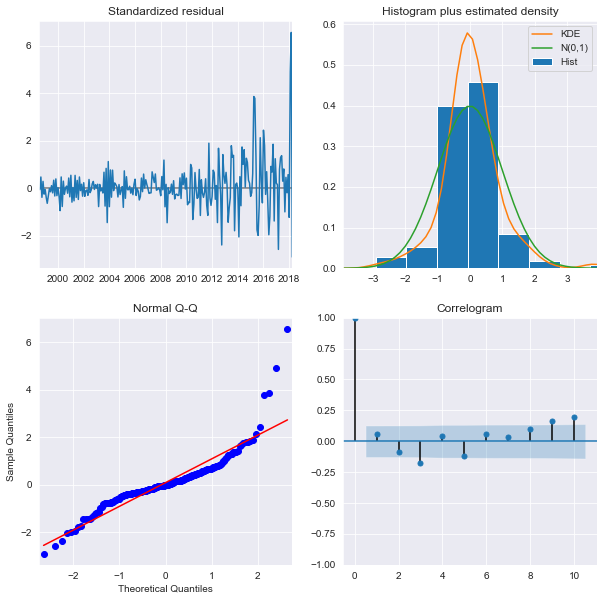

In [55]:
output.plot_diagnostics(figsize=(10, 10))
plt.show()

Top right: Our data is normally distributed for the most part, which is good, however the N(0,1) does not follow as well as we'd like.

Bottom left: ordered distribution of residuals (blue dots) show that we are not really following the linear trend of samples taken from the normal distribution so well.

Bottom right: Our auto-correlation plot shows that the time series residuals have some correlation with lagged versions of itself. 
____
As we are not able to confirm the assumptions of the ARIMA model, we will need some further tweaking here. Let's calculate the RMSE to get a baseline error as a benchmark.

In [56]:
pred = output.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_conf = pred.conf_int()

In [57]:
# Get the real and predicted values
toppick_forecasted = pred.predicted_mean             #series
toppick_truth = meltd_top_pick['2017-04-01':].T.squeeze()  #slicing the list and squeezing to a series also

# Compute the root mean square error
rmse = np.sqrt(((toppick_forecasted - toppick_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 5)))

The Root Mean Squared Error of our forecasts is 958.42149


So our RMSE is about 958. This means that our predictions are off by about 958 dollars out of 160k - not too bad. 

## Modifying SARIMA Model
Let's try improving our previous RMSE by widening the parameters in our loop to a range between 0 and 2.

In [58]:
# Let's set the p, d and q parameters to take any value between 0 and 2.
p = d = q = range(0, 3)

# Generates all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

**NOTE: This next cell may take a long time to run (24 min for us!).**

In [59]:
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(meltd_top_pick,
#                                             order=comb,
#                                             seasonal_order=combs,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
#         except:
#             continue

Let's now find which combo of parameters gave us the minimum AIC value.

In [60]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3530.36
Name: 63, dtype: object

Our AIC is a bit lower now.
Let's plug these new parameters into a new model and run it.

In [61]:
# Plugging those best parameter values into a new SARIMA model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(meltd_top_pick, 
                                        order=(2, 2, 2), 
                                        seasonal_order=(1, 2, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fitting the model and printing results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8164      0.066     12.283      0.000       0.686       0.947
ar.L2         -0.2147      0.086     -2.495      0.013      -0.383      -0.046
ma.L1         -0.5290      0.079     -6.656      0.000      -0.685      -0.373
ma.L2         -0.6333      0.069     -9.114      0.000      -0.770      -0.497
ar.S.L12       0.1909      0.056      3.430      0.001       0.082       0.300
ma.S.L12      -1.9476      0.099    -19.598      0.000      -2.142      -1.753
ma.S.L24       1.0004      0.098     10.201      0.000       0.808       1.193
sigma2      1.232e+05   1.58e-06   7.81e+10      0.000    1.23e+05    1.23e+05


All of our components are now within the p-value significance threshold of 0.05- a good sign.

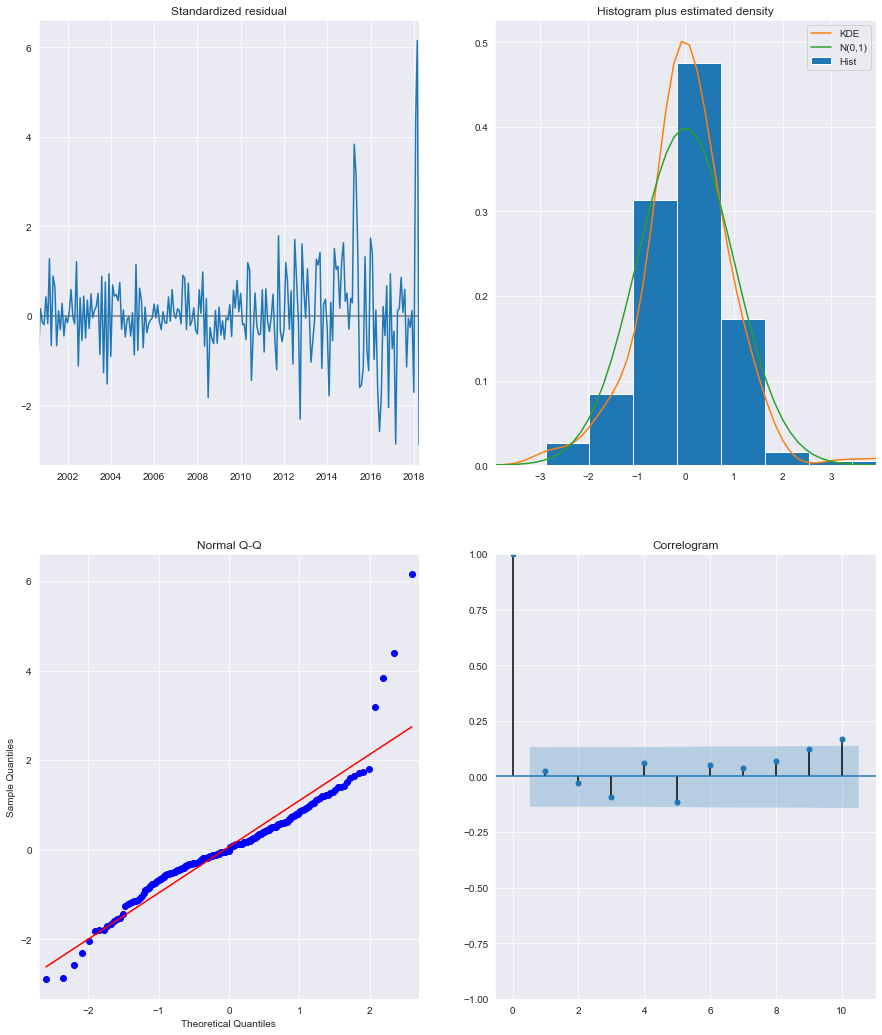

In [62]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

Slight improvements in histogram/density curve, and correlogram. Q-Q plot residuals still a bit off though.
Let's get the RMSE for this new model.

In [63]:
pred = output.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_conf = pred.conf_int()

In [64]:
# Get the real and predicted values
toppick_forecasted = pred.predicted_mean             #series
toppick_truth = meltd_top_pick['2017-04-01':].T.squeeze()  #slicing the list and squeezing to a series also

# Compute the root mean square error
rmse = np.sqrt(((toppick_forecasted - toppick_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 5)))

The Root Mean Squared Error of our forecasts is 951.36786


Our RMSE did improve (lower) a tad down to 951, from 958.

## Mod #2 ARIMA Model
Let's see if we can improve on our RMSE by removing the seasonality portion of our model. (This may be technically a sacrifice to speed up our model computation.)

In [65]:
# Let's set the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [66]:
ans = []
for comb in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(meltd_top_pick,
                                        order=comb,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
    except:
        continue

ARIMA (0, 0, 0) : AIC Calculated =6695.3792264607155
ARIMA (0, 0, 1) : AIC Calculated =6479.88211119836
ARIMA (0, 0, 2) : AIC Calculated =6412.920341426813
ARIMA (0, 1, 0) : AIC Calculated =4456.827788905307
ARIMA (0, 1, 1) : AIC Calculated =4149.407556049663
ARIMA (0, 1, 2) : AIC Calculated =3925.988802149609
ARIMA (0, 2, 0) : AIC Calculated =3919.989560807567
ARIMA (0, 2, 1) : AIC Calculated =3833.0711371359325
ARIMA (0, 2, 2) : AIC Calculated =3819.822365426322
ARIMA (1, 0, 0) : AIC Calculated =4294.766342839623
ARIMA (1, 0, 1) : AIC Calculated =4060.505101272812
ARIMA (1, 0, 2) : AIC Calculated =3839.2848262800953
ARIMA (1, 1, 0) : AIC Calculated =3934.6477791257557
ARIMA (1, 1, 1) : AIC Calculated =3838.9287228684025
ARIMA (1, 1, 2) : AIC Calculated =3818.067534901235
ARIMA (1, 2, 0) : AIC Calculated =3884.9383679836005
ARIMA (1, 2, 1) : AIC Calculated =3834.1082440717373
ARIMA (1, 2, 2) : AIC Calculated =3796.7182016431843
ARIMA (2, 0, 0) : AIC Calculated =3927.9718974067973
ARIM

In [67]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (2, 2, 2)
aic      3785.89
Name: 26, dtype: object

AIC went up here- not good. Let's run the model and get the RMSE.

In [68]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(meltd_top_pick, 
                                        order=(2, 2, 2),  
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7851      0.071     11.074      0.000       0.646       0.924
ar.L2         -0.5379      0.066     -8.187      0.000      -0.667      -0.409
ma.L1         -0.2414      0.081     -2.963      0.003      -0.401      -0.082
ma.L2         -0.2068      0.051     -4.044      0.000      -0.307      -0.107
sigma2      1.151e+05   5528.514     20.817      0.000    1.04e+05    1.26e+05


Components are in check, under the p-value threshold.  

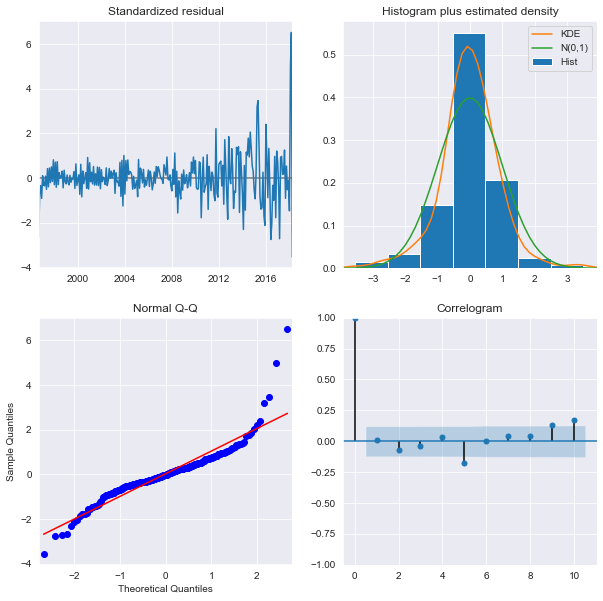

In [69]:
output.plot_diagnostics(figsize=(10, 10))
plt.show()

Our residuals remain correlated and the assumptions of the ARIMA model are violated so we can't use this model.

In [70]:
pred = output.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_conf = pred.conf_int()

In [71]:
# Get the real and predicted values
toppick_forecasted = pred.predicted_mean             #series
toppick_truth = meltd_top_pick['2017-04-01':].T.squeeze()  #slicing the list and squeezing to a series also

# Compute the root mean square error
rmse = np.sqrt(((toppick_forecasted - toppick_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 5)))

The Root Mean Squared Error of our forecasts is 876.07315


Interesting, our error actually went even lower without the seasonality! However due to the worsened assumption violations of this model, we need to tweak the parameters.

Let's try taking the log of our top zip code and fitting the ARIMA model again 
## Log Data

In [72]:
log_toppick = np.log(meltd_top_pick)

In [73]:
# Let's set the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [74]:
ans = []
for comb in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(log_toppick,
                                        order=comb,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
    except:
        continue

ARIMA (0, 0, 0) : AIC Calculated =2018.8838552658485
ARIMA (0, 0, 1) : AIC Calculated =1655.378937923599
ARIMA (0, 0, 2) : AIC Calculated =1658.0641049604258
ARIMA (0, 0, 3) : AIC Calculated =1306.2089910099303
ARIMA (0, 1, 0) : AIC Calculated =-1631.9375124845124
ARIMA (0, 1, 1) : AIC Calculated =-1887.1398908801857
ARIMA (0, 1, 2) : AIC Calculated =-2055.9167371187687
ARIMA (0, 1, 3) : AIC Calculated =-2091.682854364724
ARIMA (0, 2, 0) : AIC Calculated =-2107.7175252392
ARIMA (0, 2, 1) : AIC Calculated =-2133.3676592434276
ARIMA (0, 2, 2) : AIC Calculated =-2124.0935913124526
ARIMA (0, 2, 3) : AIC Calculated =-2157.461098355101
ARIMA (0, 3, 0) : AIC Calculated =-2010.5578097321782
ARIMA (0, 3, 1) : AIC Calculated =-2016.6144426312112
ARIMA (0, 3, 2) : AIC Calculated =-2082.238778182699
ARIMA (0, 3, 3) : AIC Calculated =-2095.1513528347646
ARIMA (1, 0, 0) : AIC Calculated =-1756.1432538164743
ARIMA (1, 0, 1) : AIC Calculated =-1988.1749203175448
ARIMA (1, 0, 2) : AIC Calculated =-2127

In [75]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (2, 0, 3)
aic     -2176.88
Name: 35, dtype: object

Our AIC is much lower, however negative. 

In [76]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_toppick, 
                                        order=(2, 0, 3),  
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9223      0.039     49.859      0.000       1.847       1.998
ar.L2         -0.9223      0.039    -23.907      0.000      -0.998      -0.847
ma.L1          0.3760      0.070      5.408      0.000       0.240       0.512
ma.L2         -0.1792      0.086     -2.096      0.036      -0.347      -0.012
ma.L3         -0.4024      0.080     -5.002      0.000      -0.560      -0.245
sigma2      1.367e-05   1.22e-06     11.183      0.000    1.13e-05    1.61e-05


Components under the threshold.

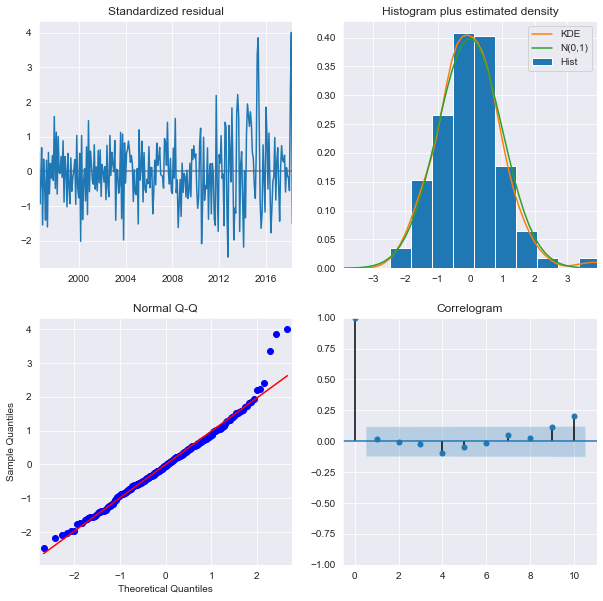

In [77]:
output.plot_diagnostics(figsize=(10, 10))
plt.show()

Using the log of our time series gave us considerably better results as far as assumptions. The end residuals on the bottom right however are slightly correlated lagged versions of itself. This may be due to the random spikes of noise that we can see in the of the top right graph.

. Let's plot the predictions and get the RMSE.


In [78]:
# Getting predictions starting from 2017-04-01 and calculating confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_conf = pred.conf_int()

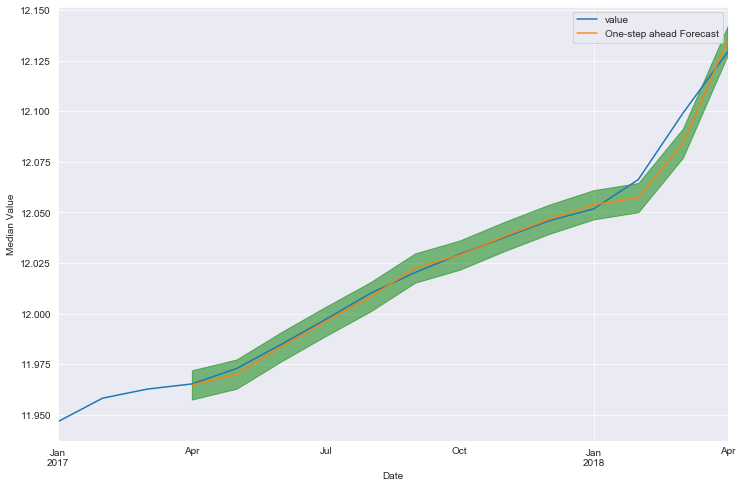

In [79]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 12, 8

# Plot observed values
ax = log_toppick['2017':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Value')
plt.legend()

plt.show()

We can see that our predictions follow our trend quite closely.

In [80]:
# Get the real and predicted values
toppick_forecasted = np.exp(pred.predicted_mean)             # np.exp = reverse the log transformed series
toppick_truth = meltd_top_pick['2017-04-01':].T.squeeze()  #slicing the list and squeezing to a series also

# Compute the root mean square error
rmse = np.sqrt(((toppick_forecasted - toppick_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 5)))
print("Latest Median Value ($):", np.round(toppick_truth[-1], 2))

The Root Mean Squared Error of our forecasts is 921.97635
Latest Median Value ($): 185200.0


Our RMSE improved again! Down to 921.9. 

Let's now plot our median value forecast for 15201!

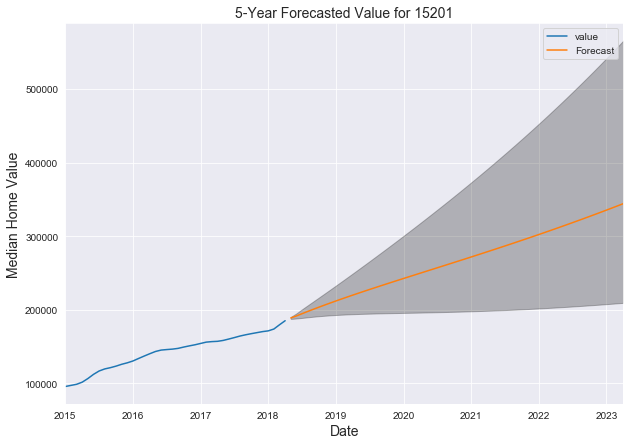

Model 5-Year Forecasted ROI rate: 82.2056%


In [81]:
# Get forecast 60 steps ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = np.exp(prediction.conf_int())

ax = meltd_top_pick['2015':].plot(label='observed', figsize=(10, 7 ))
np.exp(prediction.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('Median Home Value', size=14)
ax.set_title('5-Year Forecasted Value for 15201', size=14)
plt.legend()
plt.savefig('15201-5y-forcast.png')
plt.show()

#Forecasted 5-year return on investment
ROI = np.round(((np.exp(prediction.predicted_mean)[-1] - np.exp(prediction.predicted_mean)[0])
                /np.exp(prediction.predicted_mean[0])*100), 4)
print(f"Model 5-Year Forecasted ROI rate: {ROI}%")


For our last attempt, let's bring back seasonality with our log transformed data.

### Last Try: MOD #4, Seasonal Log Data

In [82]:
# Let's set the p, d and q parameters to take any value between 0 and 3.
p = d = q = range(0, 4)

# Generates all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

**CAUTION: This will take HOURS to run!**

In [83]:
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(log_toppick,
#                                             order=comb,
#                                             seasonal_order=combs,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
#         except:
#             continue

In [84]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ValueError: 3 columns passed, passed data had 2 columns

In [85]:
# Plugging those best parameter values into a new SARIMA model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_toppick, 
                                        order=(2, 0, 1), 
                                        seasonal_order=(0, 0, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fitting the model and printing results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7781      0.036     49.865      0.000       1.708       1.848
ar.L2         -0.7779      0.036    -21.801      0.000      -0.848      -0.708
ma.L1          0.4473      0.059      7.539      0.000       0.331       0.564
sigma2      1.459e-05   1.07e-06     13.616      0.000    1.25e-05    1.67e-05


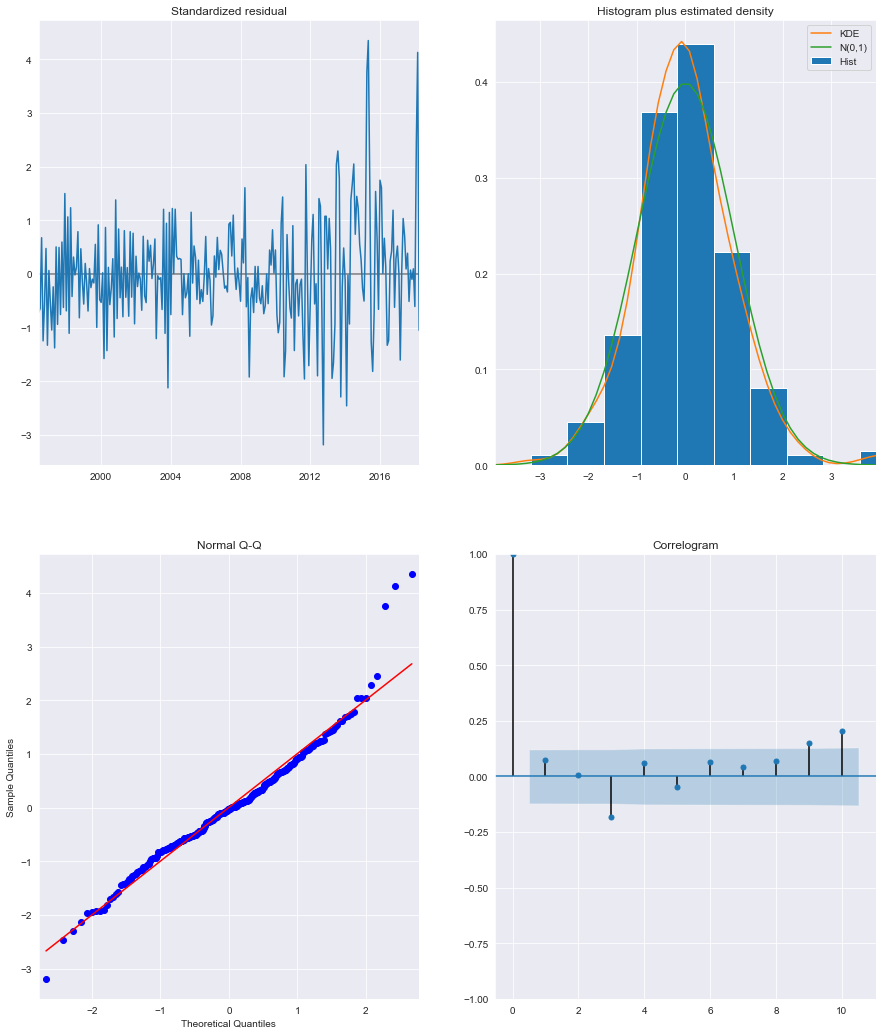

In [86]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

Our residuals correlation is a bit worse now.

In [87]:
# Getting predictions starting from 2017-04-01 and calculating confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_conf = pred.conf_int()

In [88]:
# Get the real and predicted values
toppick_forecasted = np.exp(pred.predicted_mean)             # np.exp = reverse the log transformed series
toppick_truth = meltd_top_pick['2017-04-01':].T.squeeze()  #slicing the list and squeezing to a series also

# Compute the root mean square error
rmse = np.sqrt(((toppick_forecasted - toppick_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 5)))

The Root Mean Squared Error of our forecasts is 960.28412


Worse RMSE. 

Let's go with our non-seasonal log-model!

## Modeling our narrowed-down top zip codes list to last 4/5 top ZIPs:

As our model will likely need some tuning for each different time series/ZIP code, let's make define a function for the parameter tuning, modeling process, and predictions to save space.

In [8]:
def get_best_model(df):
    
    #set the p, d and q parameters to take any value between 0 and 3
    p = d = q = range(0, 4)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    ans = []
    for comb in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=comb,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, output.aic])
#             print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue    
                
            
    # creating df out of best optimal parameters        
    ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
    best_params = ans_df.loc[ans_df['aic'].idxmin()]
    print('Best p, d, q:', best_params[0])
    #new model with best params
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                            order=best_params[0],  
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    #Fit the model and print results
    output = ARIMA_MODEL.fit()
    print(output.summary().tables[1])

#     # plot diagnostics from best model
#         output.plot_diagnostics(figsize=(15, 18))
#         plt.show()
    
    # Getting predictions starting from 2017-04-01 and calculating confidence intervals
    pred = output.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
    pred_conf = pred.conf_int()
    
    # Get the real and predicted values
    toppick_forecasted = np.exp(pred.predicted_mean)            # np.exp = reverse the log transformed series
    toppick_truth = np.exp(df['2017-04-01':].T.squeeze())  #slicing the list and squeezing to a series also

    # Compute the root mean square error
    rmse = np.sqrt(((toppick_forecasted - toppick_truth) ** 2).mean())
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 5)))
    
    #print price at time of investment
    print("Latest Median Value ($):", np.round(toppick_truth[-1], 2))
    
    # Get forecast 60 steps ahead in future
    prediction = output.get_forecast(steps=60)

    # Get confidence intervals of forecasts
    pred_conf = np.exp(prediction.conf_int())
    
    #Forecasted 5-year return on investment
    ROI = np.round(((np.exp(prediction.predicted_mean)[-1] - np.exp(prediction.predicted_mean)[0])/np.exp(prediction.predicted_mean[0])*100), 4)
    print(f"Model 5-Year Forecasted ROI rate: {ROI}%")
        
    ax = np.exp(df['2015':]).plot(label='observed', figsize=(10, 7 ))
    np.exp(prediction.predicted_mean).plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=0.25)
    ax.set_xlabel('Date', size=14)
    ax.set_ylabel('Median Home Value', size=14)
    ax.set_title('Forecasted Value', size=14)
    plt.legend()
    plt.show()

From here on, we will be taking the top contenders based on what we visualized in the time series plots for top ROIs in each tier's subgroup.

### 74740*

Best p, d, q: (2, 0, 3)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7921      0.102     17.496      0.000       1.591       1.993
ar.L2         -0.7920      0.102     -7.729      0.000      -0.993      -0.591
ma.L1          0.3969      0.117      3.398      0.001       0.168       0.626
ma.L2         -0.1197      0.145     -0.827      0.408      -0.404       0.164
ma.L3         -0.3079      0.108     -2.847      0.004      -0.520      -0.096
sigma2      2.149e-05   1.77e-06     12.143      0.000     1.8e-05     2.5e-05
The Root Mean Squared Error of our forecasts is 297.31728
Latest Median Value ($): 80100.0
Model 5-Year Forecasted ROI rate: 28.5961%


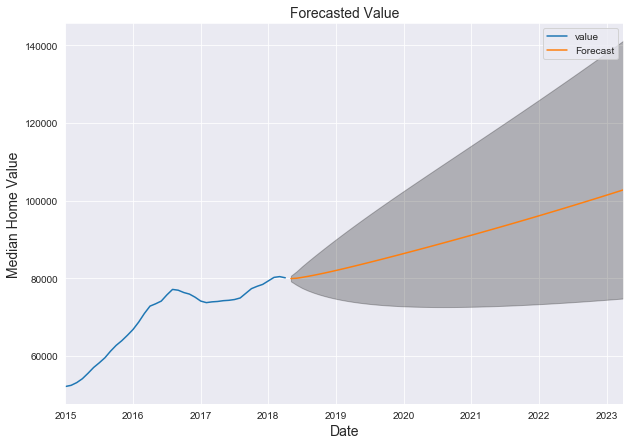

<Figure size 864x576 with 0 Axes>

In [91]:
zip74740 = melt_data(df[(df.zipcode.isin(['74740']))])
zip74740.drop(columns=['zipcode'], inplace=True)
zip74740.set_index('time', inplace=True)
log_74740 = np.log(zip74740)
get_best_model(log_74740)
plt.savefig('74740forecast.png')

Our model didn't get the best ROI compared to the others, however the RMSE is quite low comparatively.

### 38388

In [ ]:
zip38388 = melt_data(df[(df.zipcode.isin(['38388']))])
zip38388.drop(columns=['zipcode'], inplace=True)
zip38388.set_index('time', inplace=True)
log_38388 = np.log(zip38388)
get_best_model(log_38388)

As this model's p-values are all under the significance threshold, and the model is predicting a 44% return, it is a top contender!

### 15206*

In [ ]:
zip15206 = melt_data(df[(df.zipcode.isin(['15206']))])
zip15206.drop(columns=['zipcode'], inplace=True)
zip15206.set_index('time', inplace=True)
log_15206 = np.log(zip15206)
get_best_model(log_15206)

15206 is actually another zip code is Pittsburgh! The Forecasted ROI rate is 53%, and the confidence interval display almost certain increase in valuation. Top 5!

### 15213

In [ ]:
zip15213 = melt_data(df[(df.zipcode.isin(['15213']))])
zip15213.drop(columns=['zipcode'], inplace=True)
zip15213.set_index('time', inplace=True)
log_15213 = np.log(zip15213)
get_best_model(log_15213)

### 94606

In [ ]:
zip94606 = melt_data(df[(df.zipcode.isin(['94606']))])
zip94606.drop(columns=['zipcode'], inplace=True)
zip94606.set_index('time', inplace=True)
log_94606 = np.log(zip94606)



get_best_model(log_94606)

### 11222*

In [ ]:
zip11222 = melt_data(df[(df.zipcode.isin(['11222']))])
zip11222.drop(columns=['zipcode'], inplace=True)
zip11222.set_index('time', inplace=True)
log_11222 = np.log(zip11222)
get_best_model(log_11222)

### 94043*

In [ ]:
zip94043 = melt_data(df[(df.zipcode.isin(['94043']))])
zip94043.drop(columns=['zipcode'], inplace=True)
zip94043.set_index('time', inplace=True)
log_94043 = np.log(zip94043)
get_best_model(log_94043)

The confidence interval for 94043 is saying almost definite increase in this top-tier valued zipcode. 71.3244% forecasted ROI. Top 5!

### 95389

In [ ]:
zip95389 = melt_data(df[(df.zipcode.isin(['95389']))])
zip95389.drop(columns=['zipcode'], inplace=True)
zip95389.set_index('time', inplace=True)
log_95389 = np.log(zip95389)
get_best_model(log_95389)

## EXPERIMENTAL ZIPs

12901

Best p, d, q: (2, 0, 1)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7306      0.039     44.146      0.000       1.654       1.807
ar.L2         -0.7306      0.039    -18.635      0.000      -0.807      -0.654
ma.L1          0.4544      0.050      9.056      0.000       0.356       0.553
sigma2      3.403e-06    2.2e-07     15.437      0.000    2.97e-06    3.83e-06
The Root Mean Squared Error of our forecasts is 245.95873
Latest Median Value ($): 139600.0
Model 5-Year Forecasted ROI rate: 14.2282%


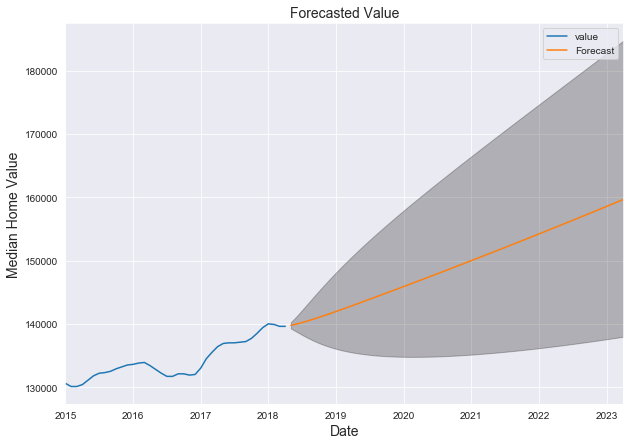

In [13]:
zip12901 = melt_data(df[(df.zipcode.isin(['12901']))])
zip12901.drop(columns=['zipcode'], inplace=True)
zip12901.set_index('time', inplace=True)
log_12901 = np.log(zip12901)
get_best_model(log_12901)

12801

Best p, d, q: (2, 0, 1)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8421      0.035     52.759      0.000       1.774       1.911
ar.L2         -0.8421      0.035    -24.112      0.000      -0.911      -0.774
ma.L1          0.3942      0.054      7.339      0.000       0.289       0.500
sigma2      5.162e-06   3.94e-07     13.113      0.000    4.39e-06    5.93e-06
The Root Mean Squared Error of our forecasts is 471.26441
Latest Median Value ($): 147100.0
Model 5-Year Forecasted ROI rate: 18.5755%


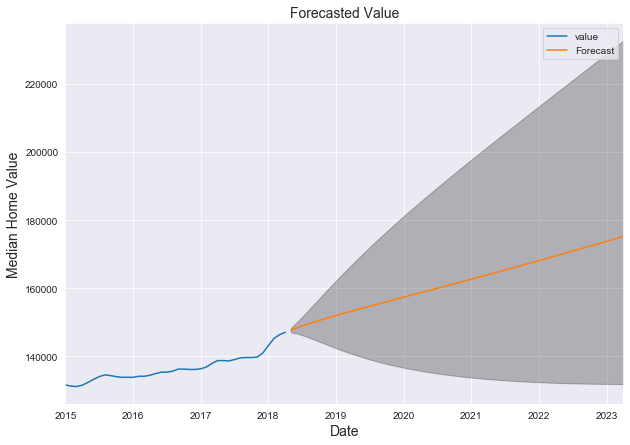

In [14]:
zip12801 = melt_data(df[(df.zipcode.isin(['12801']))])
zip12801.drop(columns=['zipcode'], inplace=True)
zip12801.set_index('time', inplace=True)
log_12801 = np.log(zip12801)
get_best_model(log_12801)

12804

Best p, d, q: (2, 0, 3)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9346      0.042     45.729      0.000       1.852       2.017
ar.L2         -0.9345      0.042    -22.087      0.000      -1.017      -0.852
ma.L1          0.5344      0.074      7.262      0.000       0.390       0.679
ma.L2         -0.1867      0.100     -1.860      0.063      -0.384       0.010
ma.L3         -0.3584      0.073     -4.887      0.000      -0.502      -0.215
sigma2      3.938e-06   2.64e-07     14.896      0.000    3.42e-06    4.46e-06
The Root Mean Squared Error of our forecasts is 853.52692
Latest Median Value ($): 224600.0
Model 5-Year Forecasted ROI rate: 28.2534%


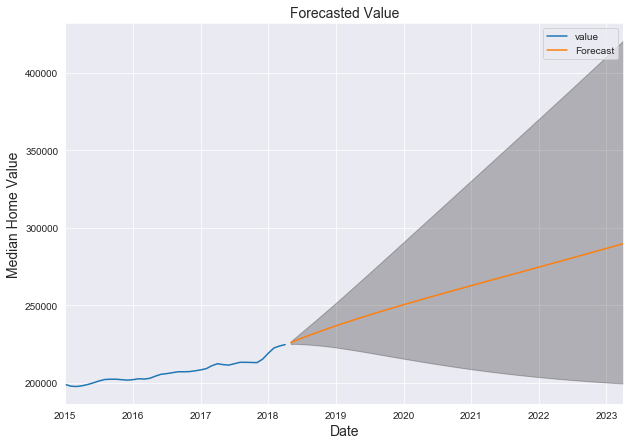

In [15]:
zip12804 = melt_data(df[(df.zipcode.isin(['12804']))])
zip12804.drop(columns=['zipcode'], inplace=True)
zip12804.set_index('time', inplace=True)
log_12804 = np.log(zip12804)
get_best_model(log_12804)

05401

In [27]:
zip05401 = melt_data(df[(df.zipcode.isin(['12804']))])

In [44]:
(df[(df.zipcode.isin(['5482']))])

,zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,5Y-ROI,10Y-ROI,15Y-ROI


In [38]:
df.zipcode.min

<bound method Series.min of 0        60657
1        75070
2        77494
3        60614
4        79936
         ...  
14718     1338
14719     3293
14720    40404
14721    81225
14722    89155
Name: zipcode, Length: 14723, dtype: int64>

# Interpretation of Results

So we created our model to the tune of our top pick ZIP code, 15201 (Pittsburgh, PA). Our optimal parameter search without seasonality gave us the best RMSE. This was likely due to the fact that the seasonality that we did observe was on such a small scale that it was insignificant. For this reason, we left seasonality out of the modeling function we used to run on the list of our narrowed-down top contenders for investments. Looking at not only profit, but the confidence interval, we made our choices and have come up with the following top 5 ZIP codes:


74740 Low-Tier Value, Forecasted 5-Year ROI: 28.5961% (McCurtain County, Oklahoma)

38388 Low-Tier Value, Forecasted 5-Year ROI: 44.3059% (Henderson County, Tennessee)

15206 Mid-Tier Value, Forecasted 5-Year ROI: 53.6248% (Pittsburgh, PA)

15201 Mid-Tier Value, Forecasted 5-Year ROI: 82.1702% (Pittsburgh, PA)

94043 High-Tier Value, Forecasted 5-Year ROI: 71.3244% (Santa Clara County, California)